In [1]:
import pandas as pd


In [2]:
import geopandas as gpd


codes = pd.read_csv("codes.csv", delimiter=";",encoding="utf-8")

regions = dict(
    frh01=gpd.read_file("/data/france/BreizhCrops/shp/raw/FRH01.shp"),
    frh02=gpd.read_file("/data/france/BreizhCrops/shp/raw/FRH02.shp"),
    frh03=gpd.read_file("/data/france/BreizhCrops/shp/raw/FRH03.shp"),
    frh04=gpd.read_file("/data/france/BreizhCrops/shp/raw/FRH04.shp")
)

annotated_shape_file_folder = "/data/france/BreizhCrops/shp/annotated"


In [3]:

english_group_names = ['common wheat','corn grain and silage','barley','other cereals',
       "rapeseed", "sunflower", "other oilseeds", "protein crops",
       'fibre plants','gel (frozen surfaces without production)','rice',
       'pulses','fodder','estives and heaths',
       "permanent meadows", "temporary meadows", "orchards",
       "vines", "nuts", "olive trees",
       'other industrial crops','vegetables or flowers',
       "sugar cane", "miscellaneous"]

french_group_names = ['Blé tendre', 'Maïs grain et ensilage', 'Orge', 'Autres céréales',
       'Colza', 'Tournesol', 'Autres oléagineux', 'Protéagineux',
       'Plantes à fibres', 'Gel (surfaces gelées sans production)', 'Riz',
       'Légumineuses à grains', 'Fourrage', 'Estives et landes',
       'Prairies permanentes', 'Prairies temporaires', 'Vergers',
       'Vignes', 'Fruits à coque', 'Oliviers',
       'Autres cultures industrielles', 'Légumes ou fleurs',
       'Canne à sucre', 'Divers']

mapping = pd.DataFrame([english_group_names,french_group_names],index=["group_name","french_group_names"]).T

codes = pd.merge(codes,mapping,left_on = "Libellé Groupe Culture",right_on = "french_group_names")

In [4]:
codes

,Code Culture,Libellé Culture,Code Groupe Culture,Libellé Groupe Culture,group_name,french_group_names
0,BTH,Blé tendre d'hiver,1,Blé tendre,common wheat,Blé tendre
1,BTP,Blé tendre de printemps,1,Blé tendre,common wheat,Blé tendre
2,MID,Maïs doux,2,Maïs grain et ensilage,corn grain and silage,Maïs grain et ensilage
3,MIE,Maïs ensilage,2,Maïs grain et ensilage,corn grain and silage,Maïs grain et ensilage
4,MIS,Maïs,2,Maïs grain et ensilage,corn grain and silage,Maïs grain et ensilage
5,ORH,Orge d'hiver,3,Orge,barley,Orge
6,ORP,Orge de printemps,3,Orge,barley,Orge
7,AVH,Avoine d'hiver,4,Autres céréales,other cereals,Autres céréales
8,AVP,Avoine de printemps,4,Autres céréales,other cereals,Autres céréales
9,BDH,Blé dur d'hiver,4,Autres céréales,other cereals,Autres céréales


add groups and group names to the shapefiles

In [5]:
for name, data in regions.items():
    regions[name] = pd.merge(data,codes,left_on = "CODE_CULTU",right_on = "Code Culture")

store annotated shapefiles

In [6]:
for name, data in regions.items():
    path = annotated_shape_file_folder + "/" + name + ".shp"
    print("saving "+path)
    regions[name].to_file(path, driver='ESRI Shapefile', encoding="utf-8")

saving /data/france/BreizhCrops/shp/annotated/frh01.shp
saving /data/france/BreizhCrops/shp/annotated/frh02.shp
saving /data/france/BreizhCrops/shp/annotated/frh03.shp
saving /data/france/BreizhCrops/shp/annotated/frh04.shp


count number of instances per group

In [7]:
counts = list()
for name, data in regions.items():
    count = data.groupby("group_name").count()["ID"]
    count.name=name
    counts.append(count)
counts = gpd.GeoDataFrame(counts).fillna(0).astype(int).T

take only crop types that appear at least 200 times in each region and 1000 times in all regions

In [8]:
minimum_instances_per_region = 250
minimum_instances_total = 1000

counts = counts.loc[(counts >= minimum_instances_per_region).all(1) & (counts.sum(1) >= minimum_instances_total)]

In [9]:
#counts.reset_index().to_csv("/home/marc/projects/ICML19_TSW/images/counts.csv")
counts

,frh01,frh02,frh03,frh04
barley,13051,10740,7154,5981
common wheat,30383,15028,27206,17012
corn grain and silage,44008,36622,42015,31369
fodder,6519,4337,7641,4542
gel (frozen surfaces without production),1522,3270,2815,4560
miscellaneous,17672,12158,21217,15594
orchards,947,350,1224,556
other cereals,6280,3663,4518,5791
permanent meadows,32664,36568,32564,26154
protein crops,1107,463,1079,658


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

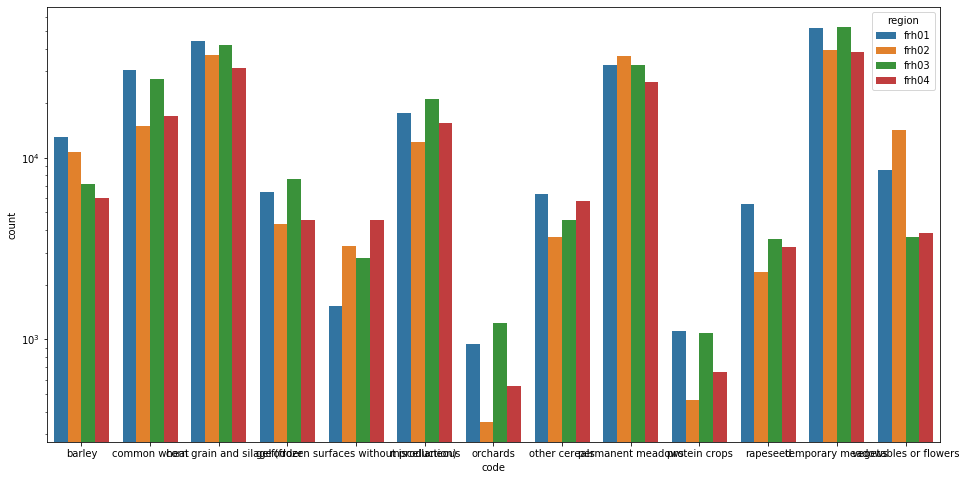

In [13]:
fig,ax = plt.subplots(1,1,figsize=(16,8))

data_=counts.stack().reset_index()
data_.columns=["code","region","count"]
ax = sns.barplot(x="code", y="count", hue="region", data=data_,ax=ax)
ax.set_yscale('log')

In [14]:
data_=counts.stack().reset_index()

In [15]:
data_.columns=["a","b","c"]

In [16]:
regions["frh04"].loc[regions["frh01"].ID==3685593]

,ID,CODE_CULTU,geometry,Code Culture,Libellé Culture,Code Groupe Culture,Libellé Groupe Culture,group_name,french_group_names


In [17]:
codes.loc[codes["Code Culture"]=="MIE"]

,Code Culture,Libellé Culture,Code Groupe Culture,Libellé Groupe Culture,group_name,french_group_names
3,MIE,Maïs ensilage,2,Maïs grain et ensilage,corn grain and silage,Maïs grain et ensilage


In [53]:
len(regions["frh03"])

207993

In [19]:
!ls data/csv/FRH0 | wc -l

ls: cannot access 'data/csv/FRH0': No such file or directory
0


In [31]:
import os
import matplotlib.ticker as ticker

In [24]:
files = os.listdir("/data/france/csv/FRH0")
Ts = list()
for f in files[:100000]:
    Ts.append(len(pd.read_csv(os.path.join("/data/france/csv/FRH0",f)).groupby("doa").first()))

In [25]:
import numpy as np
Ts = np.array(Ts)

In [26]:
counts, b = np.histogram(Ts, bins=Ts.max(), range=(0,Ts.max()), density=True)

Text(0.5, 0, 'number of observations per parcel')

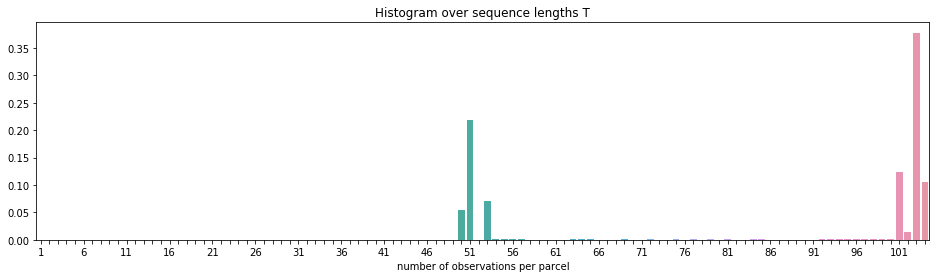

In [46]:
fig, ax = plt.subplots(figsize=(16,4))
sns.barplot(y=counts, x=np.arange(1,len(counts)+1), ax=ax)

i=0
for label in ax.get_xticklabels():
    if i%5==0:
        label.set_visible(True)
    else:
        label.set_visible(False)
    i+=1
ax.set_title("Histogram over sequence lengths T of each parcel")
ax.set_xlabel("number of observations per parcel")

In [47]:
counts

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.4160e-02,
       2.1934e-01, 5.4000e-04, 7.1630e-02, 1.9000e-03, 1.2000e-03,
       7.4000e-04, 9.5000e-04, 5.2000e-04, 3.6000e-04, 4.2000e-04,
       4.9000e-04, 4.4000e-04, 7.0000e-04, 1.1100e-03, 6.2000e-04,
       5.4000e-04, 4.4000e-04, 3.2000e-04, 5.9000e-04, 2.6000e-04,
       2.1000e-04, 6.6000e-04, 2.9000e-04, 4.7000e-04, 8.8000e

In [28]:
def load(example):
    data = pd.read_csv(example).groupby("doa").first()
    data["doa"] = pd.to_datetime(data.index)
    return data["doa"].diff().dt.days.dropna().values

delta_day = [load(os.path.join("data/csv/FRH0/",f)) for f in files[:500]]
delta_day = np.hstack(delta_day)
             
counts,_ = np.histogram(delta_day, bins=int(delta_day.max()), range=(0,int(delta_day.max())), density=True)

fig, ax = plt.subplots(figsize=(16,4))
sns.barplot(y=counts, x=np.arange(len(counts)), ax=ax)
ax.set_title("Histogram over time differences of acquisitions")
ax.set_xlabel("Number of days in between acquisitions")

FileNotFoundError: [Errno 2] File b'data/csv/FRH0/6119943.csv' does not exist: b'data/csv/FRH0/6119943.csv'

In [ ]:
delta_day = [load(os.path.join("data/csv/FRH0/",f)) for f in files[:100]]

In [ ]:
np.hstack(delta_day)

In [ ]:
import shutil

source="/home/marc/projects/BreizhCrops/data/FRH0"

region="frh01"
target = "/home/marc/projects/BreizhCrops/data/csv/"
for region in ["frh02","frh03","frh04"]:
    ids = pd.read_csv("/home/marc/projects/BreizhCrops/data/ids/"+region+".txt",header=None).values.squeeze()
    for csvid in ids:
        s = os.path.join(source,str(csvid)+".csv")
        t = os.path.join(target,region,str(csvid)+".csv")
        shutil.move(s, t)

In [ ]:
ids

In [48]:
ids

NameError: name 'ids' is not defined